#Berm Alert
RTS (January 2023)

Image classifier to distinguish between open and closed/bermed creek mouths on the coast.


References:
https://www.tensorflow.org/tutorials/images/classification



```
Requires a directory with subdirectories containing images of creek mouths

data/
  images/
    png/
      open/
      closed/

```

In [54]:
### Import packages
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.metrics import confusion_matrix

# Import Images
Load .png images into train and validation datasets.

In [2]:
### Load Images + Describe
base_folder = '/content/drive/MyDrive/projects/berm_alert/'
data_folder = os.path.join(base_folder,'data/images/png/')
#data_folder = tf.keras.utils.get_file
data_folder = pathlib.Path(data_folder)

image_count = len(list(data_folder.glob('*/*.png')))
print('Total images in data folder: {}'.format(str(image_count)))

classes = [c for c in os.listdir(data_folder) if 'README' not in c]
print('Number of classes: {}'.format(str(len(classes))))
for c in classes:
  print('  ' + c + ' - ' + \
        str(len(os.listdir(os.path.join(data_folder,c)))) + ' images')



Total images in data folder: 2289
Number of classes: 2
  open - 1060 images
  closed - 1229 images


Example Open Image:
/content/drive/MyDrive/projects/berm_alert/data/images/png/open/scott_creek_20210525_185542_55_2412_3B_Visual_clip.png


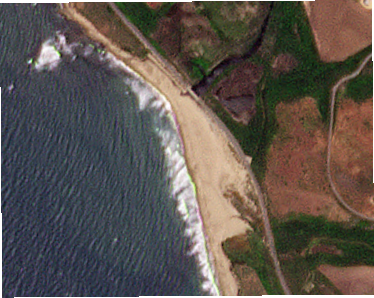



Example Closed Image:
/content/drive/MyDrive/projects/berm_alert/data/images/png/closed/malibu_creek_20210809_180100_11_227e_3B_Visual_clip.png


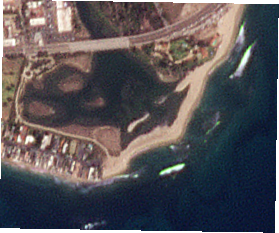

In [5]:
### Example Images
for c in classes:
  class_files = list(data_folder.glob(c + '/*.png'))
  if len(class_files) == 0:
    continue
  print('Example {} Image:'.format(c.capitalize()))
  ex_im_file = str(class_files[np.random.randint(0, len(class_files))])
  print(ex_im_file)
  im = PIL.Image.open(ex_im_file)
  display(im)
  print('\n')


In [15]:
### Create TF Datasets
'''
Ref: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
'''

# parameters
seed = 0
val_split = 0.2
batch_size = 32
img_height = 180
img_width = 180
color_mode = 'rgb'

def ds_info(dataset):
  for c in dataset.class_names:
    n_img = len([f for f in dataset.file_paths if c in f])
    print('  {}: {} images'.format(c,n_img))


# Create training and test datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_folder,
  validation_split=val_split,
  subset="training",
  class_names = ['open','closed'],
  label_mode = 'binary', # binary, int
  color_mode = color_mode, # rgb, rgba
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

ds_info(train_ds)
print('\n')

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_folder,
  validation_split=val_split,
  subset="validation",
  class_names = ['open','closed'],
  label_mode = 'binary', # binary, int
  color_mode = color_mode, # rgb, rgba
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

ds_info(val_ds)


Found 2289 files belonging to 2 classes.
Using 1832 files for training.
  open: 833 images
  closed: 999 images


Found 2289 files belonging to 2 classes.
Using 457 files for validation.
  open: 227 images
  closed: 230 images


# Basic Model
Trains a basic CNN

Ref:
https://www.tensorflow.org/tutorials/images/classification#setup

In [25]:
### Define Model

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


num_classes = len(class_names)

# Create Model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, len(color_mode))),  # normalize pixels
  layers.Conv2D(16, len(color_mode), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, len(color_mode), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, len(color_mode), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


# Compile
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 45, 45, 64)       

In [26]:
### Train Model
epochs = 10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
58/58 [==============================] - 61s 1s/step - loss: 0.6894 - accuracy: 0.5737 - val_loss: 0.5949 - val_accuracy: 0.6958
Epoch 2/10
58/58 [==============================] - 61s 1s/step - loss: 0.5427 - accuracy: 0.7129 - val_loss: 0.5710 - val_accuracy: 0.6871
Epoch 3/10
58/58 [==============================] - 63s 1s/step - loss: 0.3548 - accuracy: 0.8504 - val_loss: 0.4191 - val_accuracy: 0.8315
Epoch 4/10
58/58 [==============================] - 61s 1s/step - loss: 0.2590 - accuracy: 0.8941 - val_loss: 0.2704 - val_accuracy: 0.9059
Epoch 5/10
58/58 [==============================] - 66s 1s/step - loss: 0.2016 - accuracy: 0.9236 - val_loss: 0.2528 - val_accuracy: 0.8950
Epoch 6/10
58/58 [==============================] - 61s 1s/step - loss: 0.1794 - accuracy: 0.9307 - val_loss: 0.2147 - val_accuracy: 0.9256
Epoch 7/10
58/58 [==============================] - 61s 1s/step - loss: 0.1254 - accuracy: 0.9574 - val_loss: 0.1896 - val_accuracy: 0.9387
Epoch 8/10
58/58 [==

array([[[[  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         ...,
         [239.2131   , 197.39397  , 182.48994  ],
         [192.86418  , 163.83643  , 143.39124  ],
         [  0.       ,   0.       ,   0.       ]],

        [[  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         ...,
         [225.06131  , 189.52011  , 190.25156  ],
         [191.67728  , 178.41942  , 143.7474   ],
         [  0.       ,   0.       ,   0.       ]],

        [[ 17.027006 ,  34.95509  ,  65.582565 ],
         [ 15.79676  ,  36.146297 ,  65.4338   ],
         [ 20.137346 ,  35.084103 ,  64.58256  ],
         ...,
         [189.6047   , 167.53987  , 168.21103  ],
         [199.57106  , 170.57373  , 156.4643   ],
         [  0.       ,   0.       ,   0.       ]],

        ...,

        [[  0.       ,   0.       ,   

In [74]:
### Training Sensitivity/Specificity
data = list(train_ds.as_numpy_iterator())[:][0]

true = data[1]

probs = tf.nn.softmax(model.predict(data[0]))
pred = [np.argmax(s) for s in probs]
pred_probs = [np.max(s) for s in probs] 

cm = confusion_matrix(true, pred)
sens = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # sensitivity - TP / TP + FN
spec = cm[0, 0] / (cm[0, 1] + cm[0, 0])  # specificity - TN / TN + FP
acc = (cm[0, 0] + cm[1, 1]) / (cm[0, 0] + cm[1, 1] + cm[0, 1] + cm[1, 0])

print('\naccuracy: {}'.format(np.round(acc,5)))
print('sensitivity (closed acc): {}'.format(np.round(sens,5)))
print('specificity (open acc): {}'.format(np.round(spec,5)))

1/1 [==============================] - 0s 299ms/step

accuracy: 0.96875
sensitivity (closed acc): 0.94118
specificity (open acc): 1.0


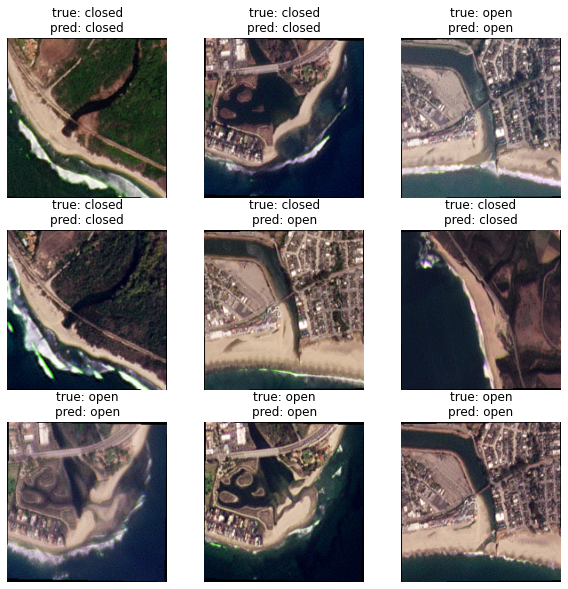

In [85]:
### Example Images and Predictions from Test DS
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)

  plt.imshow(data[0][i].astype("uint8"))
  plt.title('true: ' + class_names[int(data[1][i])] +\
            '\npred: ' + class_names[int(pred[i])])
  plt.axis("off")